## Urbanization Index Comparisons with GHS

This notebook uses several indices to classify land as "urban" and then compares those results with the Global Human Settlement (GHS) product (https://ghsl.jrc.ec.europa.eu/ghs_bu2019.php) which calculates built-up area (urban extent) up thru 2014. The indices tested here include Normalized Difference Buildup Index (NDBI), Fractional Cover (FC), and the Enhanced Normalized Difference Impervious Surface Index (ENDISI). The notebook uses only Landsat-8 to avoid issues with "banding" in the data. 

The notebook selects a region of interest and a time window for the year-2014. A median cloud-filtered mosaic is created for the year and images are then created for each index using the mosaic. In addition, a set of histograms is also created for each index. The user then selects a minimum and maximum threshold value for each index to identify potential urban pixels. Those output products are then shown. The choice and adjustment of the threshold values is supported by the histograms plots and the output comparisons with the GHS dataset (more below).

Next, the GHS dataset is loaded for the region of interest and the urban extent is shown for the year 2014. Finally, the urban extent products from each of the 3 indices is compared with the GHS product and the accuracy is evaluated. The code will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial.

# Urbanization Index Comparisons with GHS <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), 
[ga_ls8c_wofs_2_annual_summary](ga_ls8c_wofs_2_annual_summary),
* **Special requirements:** An _optional_ description of any special requirements
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
There are many different urbanization indices with different characteristics and use cases. It is often convenient to be able to compare the performance of several  indicies for an area - determining which is the best for an area based on the outputs and a "ground truth" dataset of urbanization.

## Description

This notebook uses several indices to classify land as "urban" and then compares those results with the Global Human Settlement (GHS) product (https://ghsl.jrc.ec.europa.eu/ghs_bu2019.php) which calculates built-up area (urban extent) up through 2014. The indices tested here include Normalized Difference Buildup Index (NDBI), Fractional Cover (FC), and the Enhanced Normalized Difference Impervious Surface Index (ENDISI). 

The notebook selects a region of interest and a time window for the year-2014. A median cloud-filtered mosaic is created for the year and images are then created for each index using the mosaic. In addition, a set of histograms is also created for each index. The user then selects a minimum and maximum threshold value for each index to identify potential urban pixels. Those output products are then shown. The choice and adjustment of the threshold values is supported by the histogram plots and the output comparisons with the GHS dataset (more below).

Next, the GHS dataset is loaded for the region of interest and the urban extent is shown for the year 2014. Finally, the urban extent products from each of the 3 indices is compared with the GHS product and the accuracy is evaluated. The code will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial.

1. Select a region of interest.
2. Create a cloud-filtered median mosaic with data for the year 2014.
3. Show histograms for the indicies.
4. Select minimum and maximum threshold values for the indicies to determine urban pixels.
5. Show the urbanization prediction images.
6. Load and show the "ground truth" data (GHS) for the year 2014.
7. Compare the urbanization predictions with the "ground truth" data visually and statistically.

The choice of threshold values can be informed by the histograms and comparing the urbanization prediction images with the "ground truth" urbanization data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [7]:
%matplotlib inline

import sys

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

sys.path.append("../Scripts")
from deafrica_dask import create_local_dask_cluster
# from deafrica_datahandling import calc_geomedian, load_ard, mostcommon_crs, wofs_fuser
from deafrica_plotting import display_map#, rgb

In [1]:
# # Supress Warning 
# import warnings
# warnings.filterwarnings('ignore')

# import datacube
# dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

# import matplotlib.pyplot as plt
# %matplotlib inline
# import numpy as np  
# import xarray as xr  

# import utils.data_cube_utilities.data_access_api as dc_api  
# api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36423 Dashboard: /user/jcrattz/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Urbanization_GHS_Comparison")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers water quality in Lake Manyara.

**To run the notebook for a different area**, make sure Landsat 8 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Landsat 8 (`ls8_usgs_sr_scene`).

#### Suggested areas
Here are some suggestions for areas to look at. To view one of these areas, copy and paste the parameter values into the cell below, then run the notebook.

**Dodoma, Tanzania**
```
lat = -6.1696
lon = 35.748
lat_buffer = 0.0356
lon_buffer = 0.036
```

**Dar es Salam, Tanzania**
```
lat = -6.8205
lon = 39.219
lat_buffer = 0.1505
lon_buffer = 0.129
```

**Nairobi, Kenya**
```
lat = -1.28
lon = 36.85
lat_buffer = 0.12
lon_buffer = 0.15
```

**Kumasi, Ghana**
```
lat =  6.7012
lon = -1.60825
lat_buffer = 0.1722
lon_buffer = 0.18715
```

**Dakar, Senegal**
```
lat = 14.72
lon = -17.355
lat_buffer = 0.19
lon_buffer = 0.215
```

### Select location

In [5]:
# Define the area of interest
lat = 14.72
lon = -17.355
lat_buffer = 0.19
lon_buffer = 0.215

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Time period
time_range = ("2014-01-01", "2014-01-31")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [8]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

### Select the dataset, view the bounds, select the analysis region, and select the time window

In [2]:
# # Select a Product and Platform
# # Examples: ghana, kenya, tanzania, sierra_leone, senegal

# # product = "ls8_lasrc_kenya"
# # platform = "LANDSAT_8"

# # product = "ls8_lasrc_tanzania"
# # platform = "LANDSAT_8"

# product = "ls8_lasrc_ghana"
# platform = "LANDSAT_8"

# # product = "ls8_lasrc_senegal"
# # platform = "LANDSAT_8"

In [4]:
# # Get Coordinates of the selected cube and print them

# coordinates = api.get_full_dataset_extent(platform = platform, product = product)

# latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
# longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
# time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))

# print( latitude_extents )
# print( longitude_extents )
# print( time_extents )

In [4]:
# # Select an analysis region (Lat-Lon) within the extents listed above. 
# # Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# # This region and time period will be used for the cloud assessment
# # It may be best to use the Cloud Statistics notebook to find a clear single day

# # Dodoma, Tanzania
# # latitude = (-6.2052, -6.134) 
# # longitude = (35.712, 35.784)  
# # time_extents = ('2014-01-01', '2014-12-31')

# # Dar es Salam, Tanzania
# # latitude = (-6.971, -6.67)
# # longitude = (39.09, 39.348)
# # time_extents = ('2014-01-01', '2014-12-31')

# # Nairobi, Kenya
# # latitude = (-1.4, -1.16) 
# # longitude = (36.7, 37.0) 
# # time_extents = ('2014-01-01', '2014-12-31')

# # Kumasi, Ghana
# latitude = (6.529, 6.8734) 
# longitude = (-1.7954, -1.4211) 
# time_extents = ('2014-01-01', '2014-12-31')

# # Dakar, Senegal
# # latitude = (14.5300, 14.91) 
# # longitude = (-17.57, -17.1400) 
# # time_extents = ('2014-01-01', '2014-12-31')

In [5]:
# # The code below renders a map that can be used to view the region.
# from utils.data_cube_utilities.dc_display_map import display_map
# display_map(latitude,longitude)

### Load the dataset, mask out clouds and shadows and water, and create a median mosaic

In [6]:
# Load the data including the "coastal_aerosol" band

landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1279, longitude: 1390, time: 17)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-08T10:22:46 ... 2014-12-26T10:21:58
  * latitude   (latitude) float64 6.873 6.873 6.873 6.873 ... 6.529 6.529 6.529
  * longitude  (longitude) float64 -1.796 -1.795 -1.795 ... -1.422 -1.421 -1.421
Data variables:
    red        (time, latitude, longitude) int16 707 656 644 631 ... 485 487 494
    green      (time, latitude, longitude) int16 790 750 746 739 ... 709 712 710
    blue       (time, latitude, longitude) int16 329 297 279 255 ... 340 336 339
    nir        (time, latitude, longitude) int16 2943 2891 2940 ... 565 561 557
    swir1      (time, latitude, longitude) int16 1960 1761 1714 ... 374 370 371
    swir2      (time, latitude, longitude) int16 1051 891 850 ... 261 263 260
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 324 324 324
Attributes:
    crs:      EPSG:4326

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])

# Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels (per QA band)
land_dataset = landsat_dataset.where(land_mask)

# Create a water mask using WOfS and mask out water
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
water_mask = (wofs_classify(land_dataset).wofs == 1)
land_dataset = land_dataset.where(~water_mask)

from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_hdmedians_multiple_band_mosaic

# Create a MEDIAN mosaic
land_composite = create_median_mosaic(land_dataset, (land_mask & ~water_mask))

# Land Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to the land composite. The components of the FC product are: Bare Soil (bs), Photosynthetic Vegetation (pv), Non Photosynthetic Vegetation (npv)

The FC false color output product uses RGB = bs/pv/npv
<br>RED = Bare Soil or Urban Areas
<br>BLUE = Non-Green Vegetation
<br>GREEN = Green Vegetation
<br>BLACK = Water

In [9]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite, clean_mask = np.ones(land_composite.pixel_qa.shape).astype(np.bool)) 

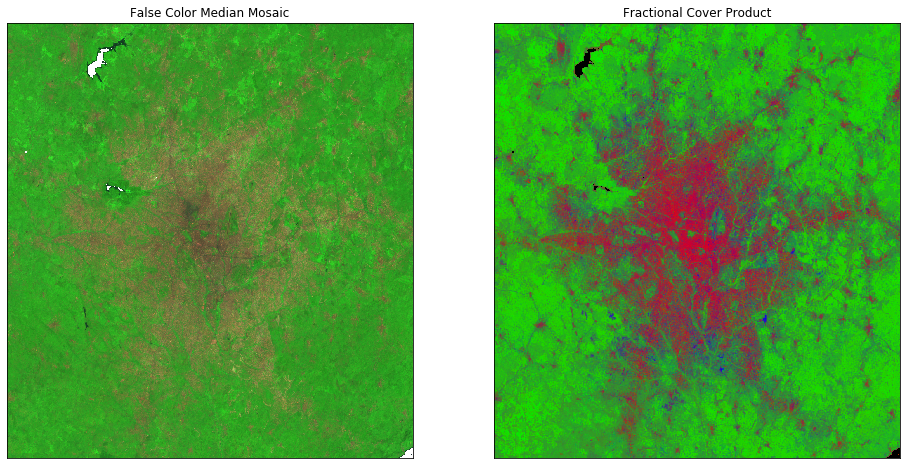

In [10]:
lc1 = land_composite[['swir2', 'nir', 'green']].to_array()
fc1 = frac_classes[['bs', 'pv', 'npv']].to_array()

fig, ax = plt.subplots(1, 2, figsize=(16,8))
(lc1).plot.imshow(ax=ax[0],vmin=0, vmax=5000)
(fc1).plot.imshow(ax=ax[1],vmin=0, vmax=100)
ax[0].set_title('False Color Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Fractional Cover Product'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

# Land Spectral Indices

In [11]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [12]:
def MNDWI(dataset):
    return (dataset.green - dataset.swir1)/(dataset.green + dataset.swir1)

In [13]:
def Swir_diff(dataset):
    return (dataset.swir1)/(dataset.swir2)

In [14]:
def Alpha(dataset):
    return (2*(np.mean(dataset.blue)))/(np.mean(Swir_diff(dataset)) + np.mean(MNDWI(dataset)*MNDWI(dataset)))     

In [15]:
def ENDISI(dataset):
    mndwi = MNDWI(dataset)
    swir_diff = Swir_diff(dataset)
    alpha = Alpha(dataset)
    return (dataset.blue - (alpha)*(swir_diff + mndwi*mndwi))/(dataset.blue + (alpha)*(swir_diff + mndwi*mndwi))

In [16]:
ndbi = NDBI(land_composite) # Normalized Difference Build Up (Urbanization) Index
endisi = ENDISI(land_composite) # Enhanced Normalized Difference Impervious Surface Index

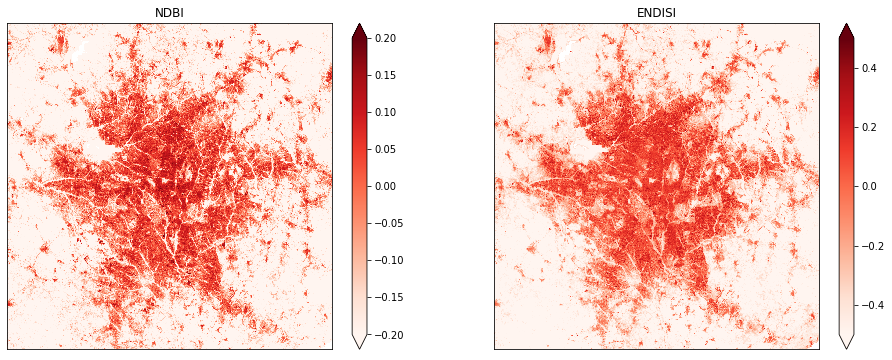

In [17]:
# Normalized Difference Buildup Index (NDBI)
# Enhanced Normalized Difference Impervious Surface Index (ENDISI)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
(ndbi).plot.imshow(ax=ax[0],cmap = "Reds", vmin=-0.2, vmax=0.2)
(endisi).plot.imshow(ax=ax[1],cmap = "Reds", vmin=-0.5, vmax=0.5)
ax[0].set_title('NDBI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

## Histogram Plots

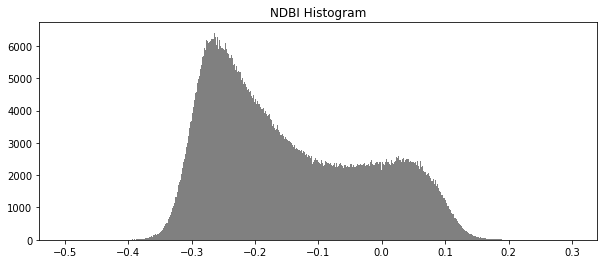

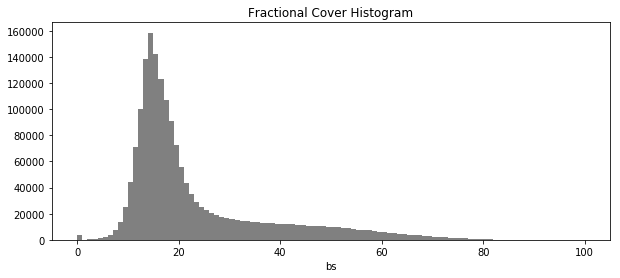

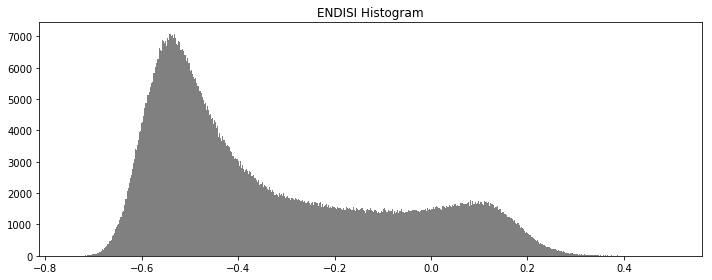

In [18]:
# These histogram plots can be used to review the range of values for each product
# The urban threshold values are often chosen using these histograms

ndbi.plot.hist(bins=1000, range=(-0.5,0.3), facecolor='gray', figsize=(10, 4))
plt.title('NDBI Histogram')
frac_classes.bs.plot.hist(bins=100, range=(0,100), facecolor='gray', figsize=(10, 4))
plt.title('Fractional Cover Histogram')
endisi.plot.hist(bins=1000, range=(-0.75,0.50), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram')

plt.tight_layout()
plt.show()

## Create Threshold Plots
First we will define a minimum threshold and a maximum threshold for each index. Then we will create plots that color the threshold region a single color (e.g. red).

In [19]:
from matplotlib.ticker import FuncFormatter
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from utils.data_cube_utilities.dc_rgb import rgb

def threshold_plot(ds, da, min_threshold, max_threshold, 
                   mask = None, width = 10, filter_size=1, 
                   fig = None, ax = None, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    inside  = remove_small_objects(inside, min_size=filter_size+1, connectivity=2)
    inside  = remove_small_holes(inside, min_size=filter_size+1, connectivity=2)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    rgb(ds, bands=['swir1', 'swir1', 'swir1'],
        paint_on_mask=[(inside, color_in), (masked, color_cloud)], 
        fig=fig, ax=ax)
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))

In [20]:
# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI -0.1 to 0.3 is typical for urban areas
min_ndbi_threshold = -0.05
max_ndbi_threshold = 0.2

# ENDISI = -1.0 to 1.0 (full range)
# ENDISI -0.2 to 0.4 is typical for urban areas
min_endisi_threshold = -0.1
max_endisi_threshold = 0.4

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) 30 to 100 is typical for urban areas
min_fc_threshold = 30.0
max_fc_threshold = 100.0

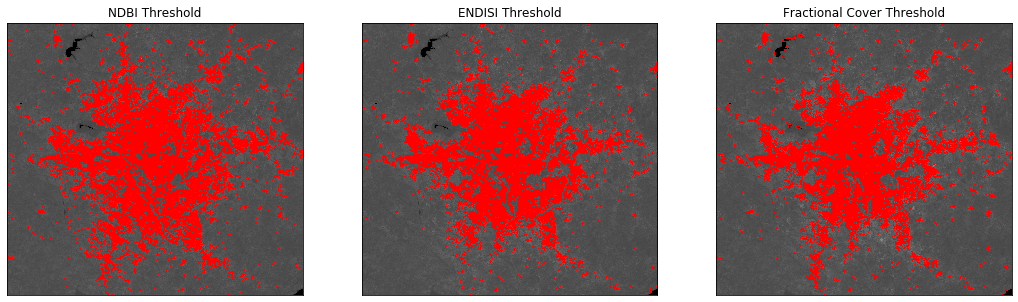

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

threshold_plot(land_composite, ndbi, min_ndbi_threshold, max_ndbi_threshold, ax=ax[0])
threshold_plot(land_composite, endisi, min_endisi_threshold, max_endisi_threshold, ax=ax[1])
threshold_plot(land_composite, frac_classes.bs, min_fc_threshold, max_fc_threshold, ax=ax[2])

ax[0].set_title('NDBI Threshold'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI Threshold'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title('Fractional Cover Threshold'), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False)
plt.show()

## Comparison Metrics
We will compare the performance of the urban index results against the GHS GeoTIFF product (shown below). We can load the GeoTIFF by utilizing datacube's internal raster reader. This will reproject and transform the image to fit the dataset loaded previously.

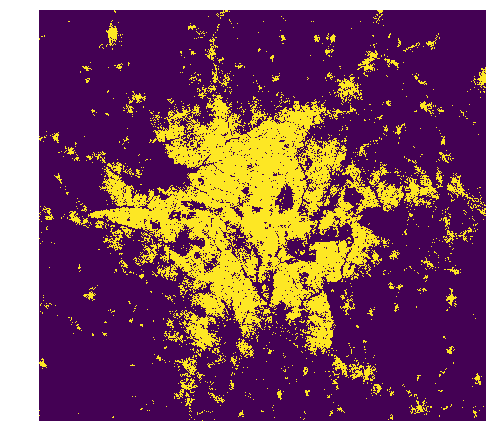

In [22]:
from datacube.storage.storage import read_from_source, RasterFileDataSource
from rasterio.warp import Resampling

# Southern Ghana
tif = './geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_11.tif'

# Kenya
# tif = './geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif'

# Tanzania
# tif = './geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_12.tif'

# Senegal
# tif = './geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif'

dst = np.zeros(land_dataset.isel(time=0).red.values.shape)
rio = RasterFileDataSource(tif, 1)
read_from_source(rio, dst, land_dataset.geobox.transform, 0, 'EPSG:4326',  Resampling.nearest)

actual = (dst >= 3) & (dst <= 6)
fig = plt.figure(figsize=(8,8))
plt.imshow(actual)
plt.axis('off')
plt.show()

## Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 
<br><br>Accuracy = (True Positive + True Negative) / (Total Pixels) 
<br>F1 Score is the weighted average of Precision and Recall. 
<br>Precision = TP/TP+FP
<br>Recall = TP/TP+FN
<br>F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [23]:
from collections import namedtuple
import pandas as pd

def get_metrics(actual, predicted, minimum_threshold, maximum_threshold, filter_size=1):
    """ Creates performance metrics.
    
    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        minimum_threshold: the minimum threshold to apply on the predicted values for generating a boolean mask.
        maximum_threshold: the maximum threshold to apply on the predicted values for generating a boolean mask.
        filter_size: the filter size to apply on predicted to remove small object/holes with.
        
    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple('Metrics',
                         'actual predicted true_positive true_negative false_positive false_negative')

    predicted  = np.logical_and(predicted > minimum_threshold, predicted < maximum_threshold)
    predicted  = remove_small_objects(predicted, min_size=filter_size+1, connectivity=2)
    predicted  = remove_small_holes(predicted, min_size=filter_size+1, connectivity=2)

    true_positive=(predicted & actual).sum()
    true_negative=(~predicted & ~actual).sum()
    false_positive=(predicted & ~actual).sum()
    false_negative=(~predicted & actual).sum()

    return metrics(actual=actual,
                   predicted=predicted,
                   true_positive=true_positive,
                   true_negative=true_negative,
                   false_positive=false_positive,
                   false_negative=false_negative)

def print_metrics(metrics):
    norm = metrics.true_positive + metrics.false_negative + metrics.false_positive + metrics.true_negative
    accuracy = (metrics.true_positive + metrics.true_negative)/norm
    ppv = metrics.true_positive/(metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive/(metrics.true_positive + metrics.false_negative)
    f1 = (2*ppv*tpr)/(ppv+tpr)
    
    print('True Positive (Actual + Model = Urban): {tp}'.format(tp=round(metrics.true_positive/norm*100,3)))
    print('True Negative (Actual + Model = Non-Urban): {tn}'.format(tn=round(metrics.true_negative/norm*100,3)))
    print('False Positive (Actual=Non-Urban, Model=Urban): {fp}'.format(fp=round(metrics.false_positive/norm*100,3)))
    print('False Negative (Actual=Urban, Model=Non-Urban): {fn}'.format(fn=round(metrics.false_negative/norm*100,3)))
    print('\nAccuracy: {accuracy}'.format(accuracy=round(accuracy*100, 3)))
    print('F1 Score: {f1}\n'.format(f1=round(f1*100, 3)))

In [24]:
print ('\033[1m' + '\033[91m' + 'NDBI - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
ndbi_metrics = get_metrics(actual, ndbi.values, -0.05, 0.2)
print_metrics(ndbi_metrics)

NDBI - Comparison Results

True Positive (Actual + Model = Urban): 19.101
True Negative (Actual + Model = Non-Urban): 71.937
False Positive (Actual=Non-Urban, Model=Urban): 6.349
False Negative (Actual=Urban, Model=Non-Urban): 2.613

Accuracy: 91.038
F1 Score: 80.998



In [25]:
print ('\033[1m' + '\033[91m' + 'ENDISI - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
endisi_metrics = get_metrics(actual, endisi.values, -0.1, 0.4)
print_metrics(endisi_metrics)

ENDISI - Comparison Results

True Positive (Actual + Model = Urban): 18.677
True Negative (Actual + Model = Non-Urban): 75.851
False Positive (Actual=Non-Urban, Model=Urban): 2.435
False Negative (Actual=Urban, Model=Non-Urban): 3.037

Accuracy: 94.528
F1 Score: 87.223



In [26]:
print ('\033[1m' + '\033[91m' + 'Fractional Cover Base Soil - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
frac_bs_metrics = get_metrics(actual, frac_classes.bs.values, 30, 100)
print_metrics(frac_bs_metrics)

Fractional Cover Base Soil - Comparison Results

True Positive (Actual + Model = Urban): 18.403
True Negative (Actual + Model = Non-Urban): 75.944
False Positive (Actual=Non-Urban, Model=Urban): 2.342
False Negative (Actual=Urban, Model=Non-Urban): 3.311

Accuracy: 94.347
F1 Score: 86.687



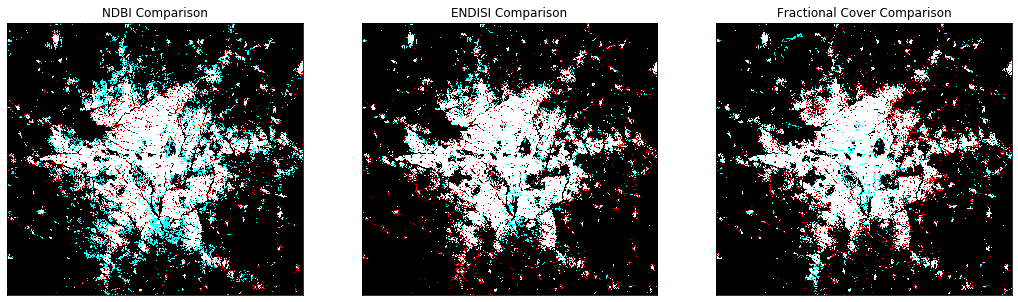

In [27]:
# Output Comparisons
# Black: Actual & Predicted No Urban (True Negative)
# Cyan: Predicted Urban (False Positive)
# Red: Actual Urban (False Negative)
# White: Actual & Predicted Urban (True Positive)

fig, ax = plt.subplots(1, 3, figsize=(18,6))

ax[0].imshow(np.dstack((ndbi_metrics.actual.astype(float),ndbi_metrics.predicted.astype(float),ndbi_metrics.predicted.astype(float))))
ax[1].imshow(np.dstack((endisi_metrics.actual.astype(float),endisi_metrics.predicted.astype(float),endisi_metrics.predicted.astype(float))))
ax[2].imshow(np.dstack((frac_bs_metrics.actual.astype(float),frac_bs_metrics.predicted.astype(float),frac_bs_metrics.predicted.astype(float))))

ax[0].set_title('NDBI Comparison'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI Comparison'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title('Fractional Cover Comparison'), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False)
plt.show()